In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## 1. ConvNet

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [3]:
# get training and validation data
x_train,y_train,x_valid,y_valid = get_data()

# normalize validation data to training data
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

# number of hidden layers, batch size
nh,bs = 50,512

# number of digit classes 
c = y_train.max().item()+1

# specify loss function
loss_func = F.cross_entropy

# create a DataBunch
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
# callback function to resize flattened image back into a 2D array
mnist_view = view_tfm(1,28,28)

# list of callback functions
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
# list number of channels for each desired convolution layer
nfs = [8, 16, 32, 64, 64]

In [6]:
# construct Learner and Runner objects for our model
# highest learning rate is 0.4
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [2.11302234375, tensor(0.2450, device='cuda:0')]
valid: [1.101391015625, tensor(0.6412, device='cuda:0')]
train: [0.486421015625, tensor(0.8397, device='cuda:0')]
valid: [0.3904976806640625, tensor(0.8742, device='cuda:0')]
Wall time: 7.01 s


## 2. Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [8]:
class BatchNorm(nn.Module):
    
    '''
    NOTES
     
        the input tensor x has four dimensions
        0: batches
        1: channels
        2: y index of weight array pixel
        3: x index of weight array pixel

        for each channel, we compute the mean and var of the weights matrix over all samples

    '''
    
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        # m and v are each of dimension (1,n_channels,1,1)
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        
        # compute exponentially weighted moving average (EWMA)
        # lerp_ means linear interpolation between last and next-to-last value
        # pytorch 'flips' meaning of momentum
        #     i.e. x(j) = x(j)*0.1 + x(j-1)*0.9
        #     i.e. x(j) = x(j)*mom + x(j-1)*(1-mom)
        #     where 0.9 is 1-mom and 0.1 is mom
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        # in validation phase, gradients are not being calculated
        # so we don't need to specify torch.no_grad()
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [9]:
# refactor conv_layer to add a BatchNorm option
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias needed if using batchnorm
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [10]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

Note: the wiggles at the end of batches are from the validation batches, which were included due to an error in the code.

In [11]:
# learning rate = 0.9
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.261214453125, tensor(0.9188, device='cuda:0')]
valid: [0.1240034423828125, tensor(0.9618, device='cuda:0')]


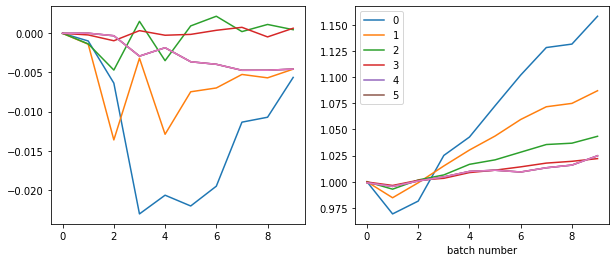

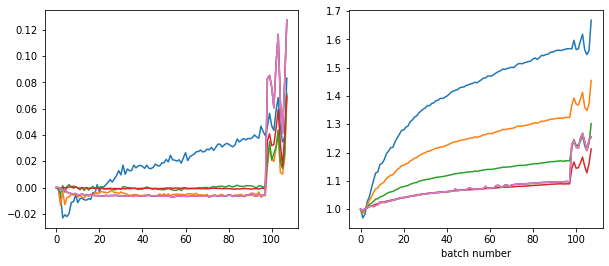

In [12]:
# one epoch
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        plt.xlabel('batch number')
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        plt.xlabel('batch number')


In [13]:
learn.model.training

False

In [14]:
# learning rate = 1.0
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [15]:
# 3 epochs
%time run.fit(3, learn)

train: [0.25653595703125, tensor(0.9190, device='cuda:0')]
valid: [0.13524683837890625, tensor(0.9588, device='cuda:0')]
train: [0.0848619140625, tensor(0.9739, device='cuda:0')]
valid: [0.1273967529296875, tensor(0.9589, device='cuda:0')]
train: [0.061883603515625, tensor(0.9808, device='cuda:0')]
valid: [0.0793875244140625, tensor(0.9761, device='cuda:0')]
Wall time: 6.21 s


### Now that we have built our own version of `BatchNorm` we are allowed to Refactor `conv_layer` to include PyTorch's builtin `BatchNorm2d`

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

In [16]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [40]:
# learning rate = 1.0
learn,run = get_learn_run(nfs, data, 2., conv_layer, cbs=cbfs)

In [41]:
%time run.fit(3, learn)

train: [0.25601177734375, tensor(0.9229, device='cuda:0')]
valid: [0.0908326416015625, tensor(0.9736, device='cuda:0')]
train: [0.099279052734375, tensor(0.9702, device='cuda:0')]
valid: [0.06887020874023438, tensor(0.9807, device='cuda:0')]
train: [0.0730422998046875, tensor(0.9775, device='cuda:0')]
valid: [0.05008526611328125, tensor(0.9856, device='cuda:0')]
Wall time: 48.4 s


### With learning rate scheduler

Now let's add the usual warm-up/annealing
We'll add the scheduler callback to the callbacks list.

Here, we find that we can go all the way to a learning rate of 2, and improve our result

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [20]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [21]:
# 8 epochs
run.fit(8, learn)

train: [0.258906875, tensor(0.9209, device='cuda:0')]
valid: [0.08668646850585937, tensor(0.9737, device='cuda:0')]
train: [0.0809163525390625, tensor(0.9746, device='cuda:0')]
valid: [0.09076246948242188, tensor(0.9723, device='cuda:0')]
train: [0.0549962158203125, tensor(0.9823, device='cuda:0')]
valid: [0.05755931396484375, tensor(0.9821, device='cuda:0')]
train: [0.03351826904296875, tensor(0.9891, device='cuda:0')]
valid: [0.05680650634765625, tensor(0.9821, device='cuda:0')]
train: [0.02082624267578125, tensor(0.9939, device='cuda:0')]
valid: [0.04784270629882813, tensor(0.9852, device='cuda:0')]
train: [0.0115502197265625, tensor(0.9970, device='cuda:0')]
valid: [0.04367476501464844, tensor(0.9877, device='cuda:0')]
train: [0.006795048217773438, tensor(0.9986, device='cuda:0')]
valid: [0.042675042724609376, tensor(0.9881, device='cuda:0')]
train: [0.004436185913085937, tensor(0.9994, device='cuda:0')]
valid: [0.04238394775390625, tensor(0.9883, device='cuda:0')]


## 3. More norms

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [22]:
class LayerNorm(nn.Module):
    '''
    NOTES
     
        the input tensor x has four dimensions
        0: samples
        1: channels
        2: y index of weight array pixel
        3: x index of weight array pixel

        for each sample, we compute the mean and var of the weights matrix over all channels

    '''
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.)) #gamma
        self.add  = nn.Parameter(tensor(0.)) #beta

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [23]:
# layer norm
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [24]:
# learning rate of 0.8
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [25]:
# layer norm doesn't work here
%time run.fit(3, learn)

train: [nan, tensor(0.2059, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
Wall time: 7.46 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm (designed for style transfer)

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [26]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # gamma
        self.adds  = nn.Parameter(torch.zeros(nf,1,1)) # beta

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [27]:
# instance norm
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [28]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [29]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
Wall time: 7.47 s


*Question*: why can't this classify anything?

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectors of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## 4. Running BatchNorm fixes the problem with small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [ ]:
# same as above
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
# takes a long time (4 min) and gets poor accuracy
%time run.fit(1, learn)

### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [30]:
class RunningBatchNorm(nn.Module):
    
    # initialize
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        
        # constants
        self.mom,self.eps = mom,eps
        
        # add scale and offset parameters to the model
        # note: nf is the number of channels
        # Q1: shouldn't self.mults and self.adds have size [1,nf,1,1]?
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        
        # register_buffer adds a persistent buffer to the module, usually used for a non-model parameter
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        # self.register_buffer('dbias', tensor(0.))
        self.batch = 0

    # compute updates to buffered tensors
    def update_stats(self, x):
        
        # batchsize, number of channels
        bs,nc,*_ = x.shape
        
        # Note: for a tensor t, t.detach_() means detach t from the computation graph, i.e. don't keep track of its gradients;
        #     the '_' prefix means do it "in place"
        # Q2: why don't we also use .detach_() for self.batch, self.count, self.step, and self.dbias?
        self.sums.detach_()
        self.sqrs.detach_()
        
        # the input x is a four-dimensional tensor: 
        #    dimensions 0, 2, 3 refer to batch samples, weight matrix rows, and weight matrix columns, respectively
        #    dimension 1 refers to channels
        dims = (0,2,3)
        
        # compute s and ss, which are the sum of the weights and the sum of the squares of the weights 
        #     over dimensions (0,2,3) for this batch. s and ss each consist of one number for each channel;
        #     because keepdim=True s, and ss are each of size [1,nf,1,1]
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        
        # Notes: 
        #   x.numel() is the number of elements in the 4-D tensor x,
        #       which is the total number of weights in the batch
        #   x.numel()/nc is the number of weights per channel in the batch
        #   y = tensor.new_tensor(x) is equivalent to y = x.clone().detach(), 
        #       the latter is the preferred way to make a copy of a tensor
        #   c is a one-dimensional tensor with a value equal to the number of weights per channel for this batch
        #       note that the number of weights per channel of a batch depends on the number of samples in the 
        #       batch; not all batches have the same number of samples
        c = self.count.new_tensor(x.numel()/nc)
        
        # momentum
        # mom1 is the 'weight' to be used in lerp_() to compute EWMAs
        #     -- see pytorch documentation for lerp_
        # if mom is 0.1 and batch size is 2, then mom1 ~ 1 - 0.9/1 = 0.1
        # if mom is 0.1 and batch size is 64, then mom1 ~ 1 - 0.9/7 ~ 0.9; 
        #     in general, mom1 increases with batch size
        # Q3: What's the logic behind the following formula for mom1?
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        # self.mom1 is a one-dimensional tensor, with a value equal to mom1
        # self.mom1 = self.dbias.new_tensor(mom1)
        
        # update EWMAs of sums, sqrs, which, like s and ss, have size [1,1,nf,1] 
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)

        # update EWMA of count
        # self.count keeps track of the EWMA of c,
        #     which is the number of weights per channel for a batch
        # Q4: why do we need the EWMA of c? Aren't batch sizes always the same, except for the last batch?
        self.count.lerp_(c, self.mom1)
        
        # Q5: what is the logic behind the following formula for dbias?
        # self.dbias = self.dbias*(1-self.mom1) + self.mom1
        
        # update the total number of samples that have been processed up to now, 
        #     i.e. the number of samples in this batch and all previous batches so far
        self.batch += bs
        
        # update the total number of batches that have been processed
        # self.step += 1

    # apply a forward pass to the current batch
    def forward(self, x):
        
        # main idea of RunningBatchNorm:
        #     to normalize the batch:
        #     in training mode, use the current EWMAs accumulated in the buffers at this step (batch), 
        #         and the *current* fitted values of the model parameters mults and adds at this step
        #     in validation mode, use the final values of the EWMAs accumulated in the buffers after training,
        #         and the final fitted values of mults and adds
        if self.training: self.update_stats(x)
            
        # get the current values of the EWMAs of sums, sqrs and count from the buffers
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        
        # if the current batch number is less than 100, scale the EWMAs by 1/self.dbias
        # Q6: Why?
        # if self.step<100:
        #   sums = sums / self.dbias
        #    sqrs = sqrs / self.dbias
        #    c    = c    / self.dbias
            
        # scale sums by 1/c to get the mean of the weights
        means = sums/c
        
        # scale sqrs by 1/c to get the mean of the squared weights
        #     then subtract the square of the mean weight from the mean of the squared weights
        # note: we recognize this as the 'computationally efficient' formula for the variance that we've seen before 
        vars = (sqrs/c).sub_(means*means)
        
        # if there are less than 20 samples so far, clamp vars to 0.01 (in case any of them becomes very small)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
            
        # normalize the batch in the usual way, i.e. subtract the mean and divide by std
        # Q7: but why do we need to add eps, when we've already clamped the vars to 0.01? 
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        
        # return a scaled and offset version of the normalized batch, where the
        #     scale factors (self.mults) and offsets (self.adds) are parameters in the model
        #     Note: there's a size mismatch: self.mults and self.adds have size [nf,1,1], while x has size [1,nf,1,1]
        return x.mul_(self.mults).add_(self.adds)

 ### description of `lerp` and `lerp_` from pytorch docs:
 
 torch.lerp(input, end, weight, out=None)

    Does a linear interpolation of two tensors start (given by input) and end based on a scalar or tensor weight and returns the resulting out tensor.
    
    out_{i} = start_{i} + weight_{i} × (end_{i} − start_{i})

    The shapes of start and end must be broadcastable. If weight is a tensor, then the shapes of weight, start, and end must be broadcastable.

    Parameters

            input (Tensor) – the tensor with the starting points

            end (Tensor) – the tensor with the ending points

            weight (float or tensor) – the weight for the interpolation formula

            out (Tensor, optional) – the output tensor.
            
 lerp_ is the in-place version of lerp
            
 When used as a method, the syntax is input.lerp_(end, weight)



In [31]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [32]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [33]:
# gets *much* better accuracy after 1 epoch
%time run.fit(1, learn)

train: [0.29023044921875, tensor(0.9165, device='cuda:0')]
valid: [0.1175947998046875, tensor(0.9631, device='cuda:0')]
Wall time: 3.51 s


This solves the small batch size issue!

## 5. How well can we do in a single epoch?

Now let's see with a decent batch size (bs=32) what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [34]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [35]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [36]:
%time run.fit(1, learn)

train: [0.16675353515625, tensor(0.9481, device='cuda:0')]
valid: [0.12615560302734374, tensor(0.9745, device='cuda:0')]
Wall time: 45.9 s


## Export

In [ ]:
nb_auto_export()

In [ ]:
nn.BatchNorm2d?